# Восстановление золота из руды

## Цель исследования
Подготовить прототип модели машинного обучения для компании, которая разрабатывает решения для эффективной работы промышленных предприятий.

## Ход исследования
Подготовка данных.На этом этапе будет проведены обзор, оценка качества данных, оценка возможности использовать данные для анализа.

Исследовательский анализ данных. Рассмотрим концентрации металлов (Au, Ag, Pb) на различных этапах очистки. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Построение и обучение модели.Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке.

## Описание данных
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


Технологический процесс

1. Флотация

Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.

На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).

2. Очистка

Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.


Описание данных


Технологический процесс


- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate ** — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота


Параметры этапов


- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи
- Наименование признаков
- Наименование признаков должно быть такое:
 [этап].[тип_параметра].[название_параметра]
 
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики
- Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

Создадим необходимое окружение для работы:

In [1]:
!pip install yellowbrick

In [2]:
!pip install pandas-profiling

In [3]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV

from sklearn.dummy import DummyRegressor


from yellowbrick.classifier import ClassificationReport
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

import warnings
warnings.filterwarnings('ignore')


### Ознакомление с данными

Откроем исходные файлы и изучим их. Для изучения напишем функцию, которая будет формировать отчет об основных характеристиках исследуемых данных.

In [4]:
df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')
df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')

In [5]:
def data_report(initial_data):
    """
   функция выводит первые 10 строк на экран,
   выводит информацию о данных методом info,
   выводит описательную статистику,
   выводит долю пропусков в столбцах
   """
    print('Общий вид таблицы с данными')
    display(initial_data.head(10))
    print('Общая информация о данных')
    display(initial_data.info())
    print('Описательная статистика данных')
    display(initial_data.describe())
    print('Доля пропусков в данных')
    display(pd.DataFrame(round(initial_data.isna().mean()*100,1)).style.background_gradient('coolwarm'))
    

In [6]:
data_report(df_full)

Общий вид таблицы с данными


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                             

None

Описательная статистика данных


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


Доля пропусков в данных


,0
date,0.000000
final.output.concentrate_ag,0.000000
final.output.concentrate_pb,0.000000
final.output.concentrate_sol,1.100000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.000000
final.output.tail_pb,0.500000
final.output.tail_sol,0.000000
final.output.tail_au,0.000000


In [7]:
data_report(df_test)

Общий вид таблицы с данными


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
5,2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
6,2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
7,2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
8,2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716
9,2016-09-01 09:59:59,126.961069,8.017856,7.030000,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255


Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null  

None

Описательная статистика данных


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


Доля пропусков в данных


,0
date,0.000000
primary_cleaner.input.sulfate,0.100000
primary_cleaner.input.depressant,0.100000
primary_cleaner.input.feed_size,0.000000
primary_cleaner.input.xanthate,0.100000
primary_cleaner.state.floatbank8_a_air,0.000000
primary_cleaner.state.floatbank8_a_level,0.000000
primary_cleaner.state.floatbank8_b_air,0.000000
primary_cleaner.state.floatbank8_b_level,0.000000
primary_cleaner.state.floatbank8_c_air,0.000000


In [8]:
data_report(df_train)

Общий вид таблицы с данными


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                             

None

Описательная статистика данных


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


Доля пропусков в данных


,0
date,0.000000
final.output.concentrate_ag,0.000000
final.output.concentrate_pb,0.000000
final.output.concentrate_sol,1.500000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.000000
final.output.tail_pb,0.700000
final.output.tail_sol,0.000000
final.output.tail_au,0.000000


Итоги ознакомления с данными:


У нас есть три набора данных.
- df_full содержит наблюдений 19439, признаков 87;
- df_test содержит наблюдений 5290, признаков 53;
- df_train содержит наблюдений 14149, признаков 87.

1) В данных есть пропущенные значения. В df_test видим отсутствие ряда признаков. Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. df_full содержит обучающую и тестовую выборки со всеми признаками.

2) 'date' в формате 'object'. 

3) В данных full и train присутствуют данные о содержании серебра (Ag), вещество (Sol), свинец (Pb) и золото (Au).

4) Рассмотрены данные целевых признаков 'rougher.output.recovery', 'final.output.recovery': df_full - отсутствуют пропуски, df_test - признаки отсутствуют, df_test - - отсутствуют пропуски.



### Расчёт эффективности обогащения

Проверим правильно ли рассчитана эффективность обогащения в нашей обучающей выборке, которая лежит в столбце rougher.output.recovery. Для этого вручную расчитаем нашу эффективность по формуле:

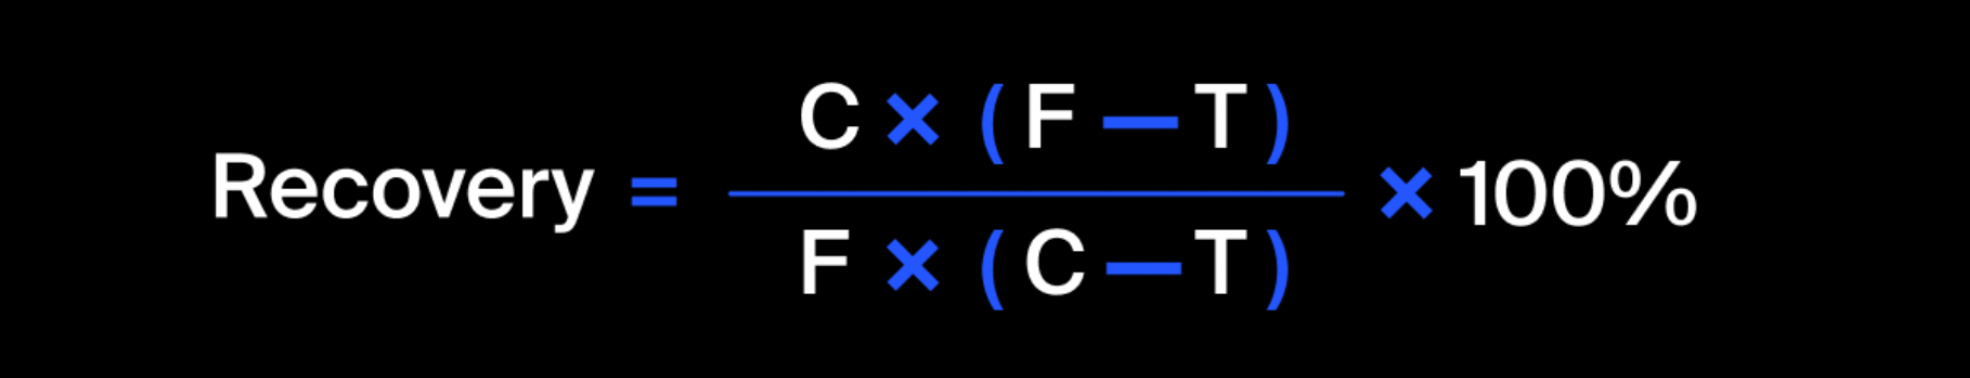

Где:

- C — доля золота в концентрате после флотации/очистки
- F — доля золота в сырье/концентрате до флотации/очистки
- T — доля золота в отвальных хвостах после флотации/очистки

In [9]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

In [10]:
recovery = C * (F - T) / (F * (C - T)) * 100


In [11]:
print(recovery.describe())

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
dtype: float64


Найдём cреднюю абсолютную ошибку между нашими расчётами и значением признака в столбце. Так мы узнаем верно ли рассчитана эффективность обогащения в нашем признаке.

MAE : метрика, которая сообщает нам среднюю абсолютную разницу между прогнозируемыми значениями и фактическими значениями в наборе данных. Чем ниже MAE, тем лучше модель соответствует набору данных.

MAE = 1/n * Σ|y i – ŷ i |

Где:

- Σ — это символ, который означает «сумма»
- y i - наблюдаемое значение для i -го наблюдения
- ŷ i - прогнозируемое значение для i -го наблюдения
- n - размер выборки

In [14]:
def MAE(recovery,y_train,df_train):
    """
   функция считает MAE
   """
    print('Средняя абсолютная разница между прогнозируемыми значениями и фактическими значениями')
    return (abs(recovery - y_train).sum()) / len(df_train)

In [15]:
MAE(recovery,df_train['rougher.output.recovery'],df_train)

Средняя абсолютная разница между прогнозируемыми значениями и фактическими значениями


9.73512347450521e-15

Вывод: MAE достаточно мало, что свидетельствует о том, что эффективность расчитана верно.

### Анализ признаков, недоступных в тестовой выборке

Посмотрим на признаки, отсутствующие в тестовой выборке.

In [16]:
print(df_train.columns.drop(df_test.columns))

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

Вывод: в тестовой выборке у нас отсутствуют все этапы на которых были получены параметры продукта из сырья. Условно, конечные значения после каждого этапа обработки. Это говорит нам о том, что мы должны удалить из  df_train все признаки, которых нет в df_test, иначе мы не построим проверяемую модель.

Удалим признаки из тренировочных данных, которых нет в тестовых.

In [17]:
drop_test = df_train.columns.drop(df_test.columns)

In [18]:
df_train.drop(drop_test, axis=1, inplace=True)

Проверим все ли столбцы удалены?

In [19]:
print(df_train.columns.drop(df_test.columns))

Index([], dtype='object')


Итог: равное количество признаков содержится в df_train и в df_test.

### Заполнение пропусков в тренировочных и тестовых данных

In [20]:
print('Колличество пропусков до обработки данных в обучающей выборке:', df_train.isnull().sum().sum())
print('Колличество пропусков до обработки данных в тестовой выборке:', df_test.isnull().sum().sum())

Колличество пропусков до обработки данных в обучающей выборке: 1705
Колличество пропусков до обработки данных в тестовой выборке: 90


Одним из основных применений DatetimeIndex является индекс для объектов pandas. Класс DatetimeIndex содержит множество оптимизаций, связанных с временными рядами. ~Мы можем использовать индексацию для заполнения пропусков.~ Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

In [21]:
df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)
df_full.set_index('date', inplace=True)

In [22]:
df_train.index, df_test.index, df_full.index

(Index(['2016-01-15 00:00:00', '2016-01-15 01:00:00', '2016-01-15 02:00:00',
        '2016-01-15 03:00:00', '2016-01-15 04:00:00', '2016-01-15 05:00:00',
        '2016-01-15 06:00:00', '2016-01-15 07:00:00', '2016-01-15 08:00:00',
        '2016-01-15 09:00:00',
        ...
        '2018-08-18 01:59:59', '2018-08-18 02:59:59', '2018-08-18 03:59:59',
        '2018-08-18 04:59:59', '2018-08-18 05:59:59', '2018-08-18 06:59:59',
        '2018-08-18 07:59:59', '2018-08-18 08:59:59', '2018-08-18 09:59:59',
        '2018-08-18 10:59:59'],
       dtype='object', name='date', length=14149),
 Index(['2016-09-01 00:59:59', '2016-09-01 01:59:59', '2016-09-01 02:59:59',
        '2016-09-01 03:59:59', '2016-09-01 04:59:59', '2016-09-01 05:59:59',
        '2016-09-01 06:59:59', '2016-09-01 07:59:59', '2016-09-01 08:59:59',
        '2016-09-01 09:59:59',
        ...
        '2017-12-31 14:59:59', '2017-12-31 15:59:59', '2017-12-31 16:59:59',
        '2017-12-31 17:59:59', '2017-12-31 18:59:59', '2017-1

Пропуски, заполним ближайшими (верхними) значениями по столбцам, поскольку из условий проекта следует, что соседние по времени параметры часто похожи.

In [26]:
df_train_for_analysis = df_train.fillna(method='ffill')
df_test_for_analysis = df_test.fillna(method='ffill')

In [27]:
print('Колличество пропусков  после обработки данных в обучающей выборке:', df_train_for_analysis.isnull().sum().sum())
print('Колличество пропусков после обработки данных в тестовой выборке:', df_test_for_analysis.isnull().sum().sum())

Колличество пропусков  после обработки данных в обучающей выборке: 0
Колличество пропусков после обработки данных в тестовой выборке: 0


Вывод: отсутствуют пропуски в тестовой и тренеровочной выборках.

### Итоги подготовки данных к анализу.

Ознакомление c наборами данных: df_full, df_test, df_train, показало что:
- в данных есть пропущенные значения. В df_test видим отсутствие ряда признаков. Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. df_full содержит обучающую и тестовую выборки со всеми признаками.

- 'date' в формате 'object'.

- df_full, df_train присутствуют данные о содержании серебра (Ag), вещество (Sol), свинец (Pb) и золото (Au).

Расчёт эффективности обогащения показал, что при вычислении MAE(средней абсолютной разницы между прогнозируемыми значениями и фактическими значениями) получено значение 9.73512347450521e-15. MAE достаточно мало, что свидетельствует о том, что эффективность расчитана верно.


Анализ признаков показал, что в тестовой выборке у нас отсутствуют все этапы на которых были получены параметры продукта из сырья - итоговые значения после каждого этапа обработки. Что привело к удалению из  df_train признаков, которые отсутствуют в df_test.


Заполнение пропусков в тренировочных и тестовых данных было осуществлено с помощью индексации данных датой и временем получения информации. На основании того, что соседние по времени параметры часто похожи, осуществили замену пропусков с использованием метода k-ближайших соседей.

В результате всех вышеперечисленных действий были подготовлены данные для анализа. 


## Анализ данных

### Анализ концентрации металлов на различных этапах очистки

In [28]:
#для удобства вывода в дальнейшем - соберем показатели в списки
rougher_input_feed_score = []
rougher_output_concentrate_score = []
primary_cleaner_output_concentrate_score = []
final_output_concentrate_score = []
metal_name = []

Необходимо из данных выделить необходимые нам значения. Отберём их по названию металла в столбцах
далее рассмотрим концентрацию для каждого металла:

- сырьё в исходном виде
- после флотации
- после первичной обработки
- финальный концентрат.

- для золота 'au'

In [29]:
print(df_full.filter(regex='au').columns)

Index(['final.output.concentrate_au', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.input.feed_au',
       'rougher.output.concentrate_au', 'rougher.output.tail_au',
       'secondary_cleaner.output.tail_au'],
      dtype='object')


In [30]:
au_in_full = df_full[['rougher.input.feed_au', 'rougher.output.concentrate_au',\
                      'primary_cleaner.output.concentrate_au',\
                      'final.output.concentrate_au']].dropna()

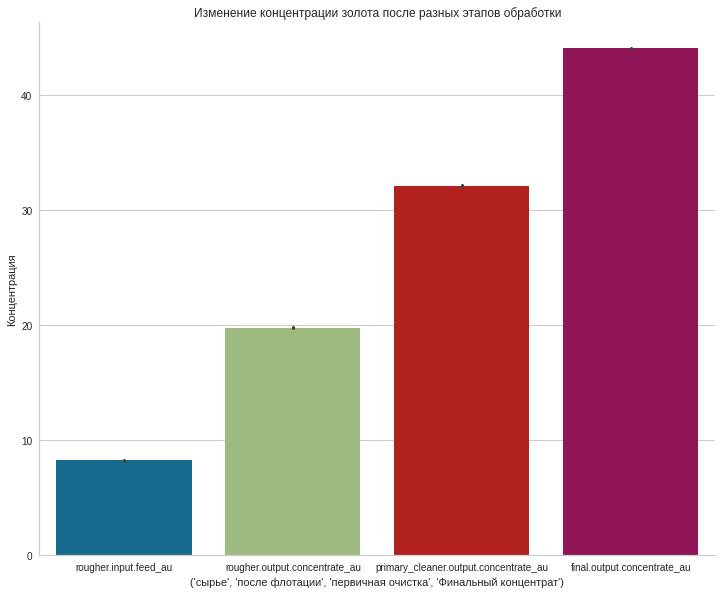

In [32]:
sns.catplot(data=au_in_full, kind='bar', legend=True, height=8, aspect=10/8)
plt.title('Изменение концентрации золота после разных этапов обработки')
plt.ylabel('Концентрация')
plt.xlabel(('сырье', 'после флотации', 'первичная очистка', 'Финальный концентрат'))
plt.show()

In [33]:
rougher_input_feed_score.append(au_in_full['rougher.input.feed_au'].median())
rougher_output_concentrate_score.append(au_in_full['rougher.output.concentrate_au'].median())
primary_cleaner_output_concentrate_score.append(au_in_full['primary_cleaner.output.concentrate_au'].median())
final_output_concentrate_score.append(au_in_full['final.output.concentrate_au'].median())
metal_name.append('Au')

- для серебра 'ag'

In [34]:
print(df_full.filter(regex="ag").columns)

Index(['final.output.concentrate_ag', 'final.output.tail_ag',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.tail_ag', 'rougher.input.feed_ag',
       'rougher.output.concentrate_ag', 'rougher.output.tail_ag',
       'secondary_cleaner.output.tail_ag'],
      dtype='object')


In [35]:
ag_in_full = df_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag',\
                      'primary_cleaner.output.concentrate_ag',\
                      'final.output.concentrate_ag']].dropna()

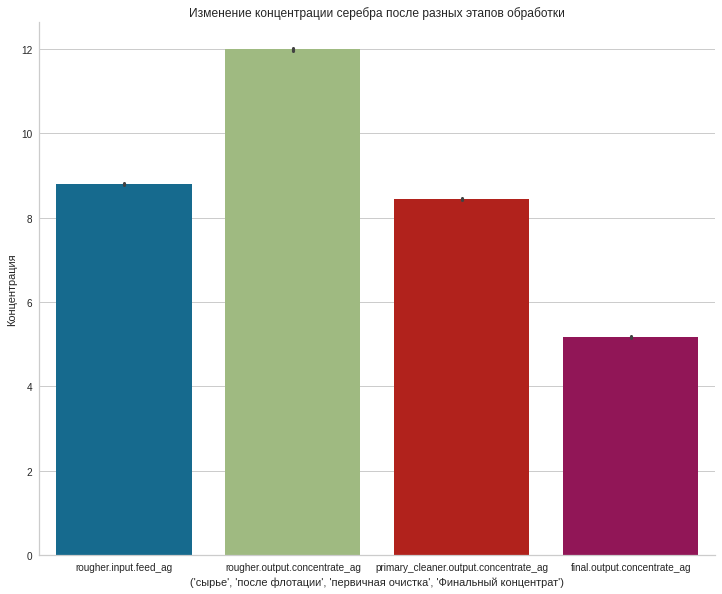

In [37]:
sns.catplot(data=ag_in_full, kind='bar', legend=True, height=8, aspect=10/8)
plt.title('Изменение концентрации серебра после разных этапов обработки')
plt.ylabel('Концентрация')
plt.xlabel(('сырье', 'после флотации', 'первичная очистка', 'Финальный концентрат'))
plt.show()

In [38]:
rougher_input_feed_score.append(ag_in_full['rougher.input.feed_ag'].median())
rougher_output_concentrate_score.append(ag_in_full['rougher.output.concentrate_ag'].median())
primary_cleaner_output_concentrate_score.append(ag_in_full['primary_cleaner.output.concentrate_ag'].median())
final_output_concentrate_score.append(ag_in_full['final.output.concentrate_ag'].median())
metal_name.append('Ag')

- для свинца pb

In [39]:
print(df_full.filter(regex="pb").columns)

Index(['final.output.concentrate_pb', 'final.output.tail_pb',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.tail_pb', 'rougher.calculation.au_pb_ratio',
       'rougher.input.feed_pb', 'rougher.output.concentrate_pb',
       'rougher.output.tail_pb', 'secondary_cleaner.output.tail_pb'],
      dtype='object')


In [40]:
pb_in_full = df_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',\
                      'primary_cleaner.output.concentrate_pb',\
                      'final.output.concentrate_pb']].dropna()

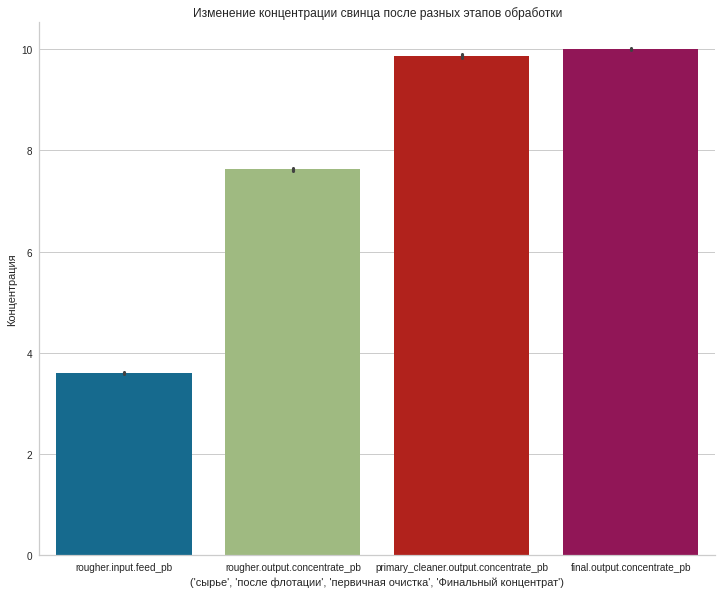

In [42]:
sns.catplot(data=pb_in_full, kind='bar', legend=True, height=8, aspect=10/8)
plt.title('Изменение концентрации свинца после разных этапов обработки')
plt.ylabel('Концентрация')
plt.xlabel(('сырье', 'после флотации', 'первичная очистка', 'Финальный концентрат'))
plt.show()

In [43]:
rougher_input_feed_score.append(pb_in_full['rougher.input.feed_pb'].median())
rougher_output_concentrate_score.append(pb_in_full['rougher.output.concentrate_pb'].median())
primary_cleaner_output_concentrate_score.append(pb_in_full['primary_cleaner.output.concentrate_pb'].median())
final_output_concentrate_score.append(pb_in_full['final.output.concentrate_pb'].median())
metal_name.append('Pb')

In [44]:
table_of_metal_concentrations = (pd.DataFrame({'Наименование металла':metal_name,\
                                               'Концентрация до флотации':rougher_input_feed_score,\
                                               'Концентрация после флотации':rougher_output_concentrate_score,\
                                               'Концентрация после первичной очистки':primary_cleaner_output_concentrate_score,\
                                               'Финальный концентрат':final_output_concentrate_score,
                                              }).
                                 sort_values(by='Финальный концентрат', ascending=False).
                                 reset_index(drop=True))
table_of_metal_concentrations

,Наименование металла,Концентрация до флотации,Концентрация после флотации,Концентрация после первичной очистки,Финальный концентрат
0,Au,8.125839,20.280214,32.841295,45.011244
1,Pb,3.539122,7.751543,10.164130,10.115748
2,Ag,8.593648,12.098115,8.507349,5.066094


Вывод: данные свидетельствуют о том, что с каждым этапом очистки концентрация золота заметно увеличивается, в то время как концентрация серебра наоборот снижается. Свинец показывает небольшое увелечение концентрации. 

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Рассмотрим распределение значений в колонках, содержащих размеры гранул сырья.

In [45]:
print(df_test_for_analysis['rougher.input.feed_size'].describe())

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64


In [46]:
print(df_train_for_analysis['rougher.input.feed_size'].describe())

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64


Визуализируем распределение данных. Ограничим графики, исключив значительную область выборосов.

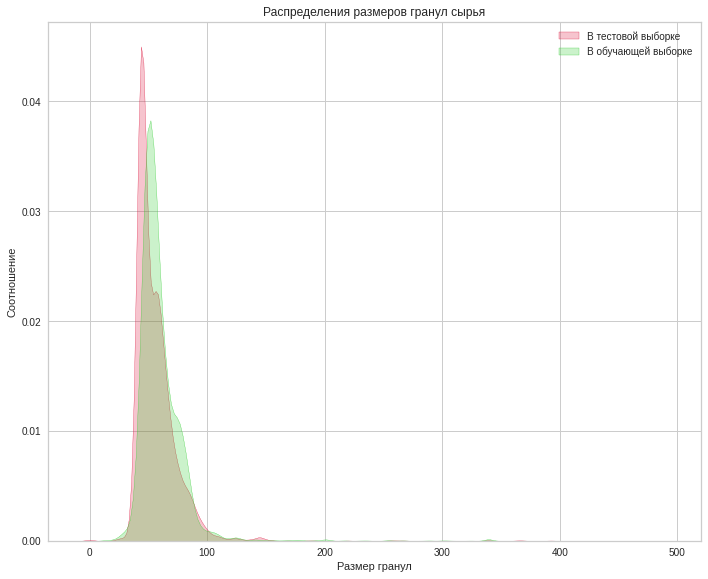

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.kdeplot(data=df_test_for_analysis['rougher.input.feed_size'],
            color='crimson', label='В тестовой выборке' , fill=True, ax=ax)
sns.kdeplot(data=df_train_for_analysis['rougher.input.feed_size'],
            color='limegreen', label='В обучающей выборке', fill=True, ax=ax)
ax.legend()
plt.tight_layout()
plt.title('Распределения размеров гранул сырья')
plt.ylabel('Соотношение')
plt.xlabel('Размер гранул')
plt.show()

Вывод: распределения не сильно отличаются друг от друга, оценка модели будет правильной.

### Суммарная концентрация всех веществ на разных стадиях

Рассмотрим какие признаки во всех датасетах имеют отношение к стадииям: сырьë, черновой концентрат, финальный концентрат.

In [49]:
print(df_full.filter(regex="rougher.input.feed").columns)

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au'],
      dtype='object')


In [50]:
print(df_full.filter(regex="rougher.output.concentrate").columns)

Index(['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
       'rougher.output.concentrate_sol', 'rougher.output.concentrate_au'],
      dtype='object')


In [51]:
print(df_full.filter(regex="final.output.concentrate").columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au'],
      dtype='object')


Создадим данные для визуализации по каждой стадии концентрации всех веществ.

In [52]:
rougher_input_feed_concentrate = df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_pb'] +\
            df_full['rougher.input.feed_sol'] + df_full['rougher.input.feed_au']
rougher_output_concentrate = df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_pb'] +\
            df_full['rougher.output.concentrate_sol'] + df_full['rougher.output.concentrate_au']
final_output_concentrate = df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_pb'] +\
            df_full['final.output.concentrate_sol'] + df_full['final.output.concentrate_au']

Построим график суммарной концентрации всех веществ на разных стадиях производства.

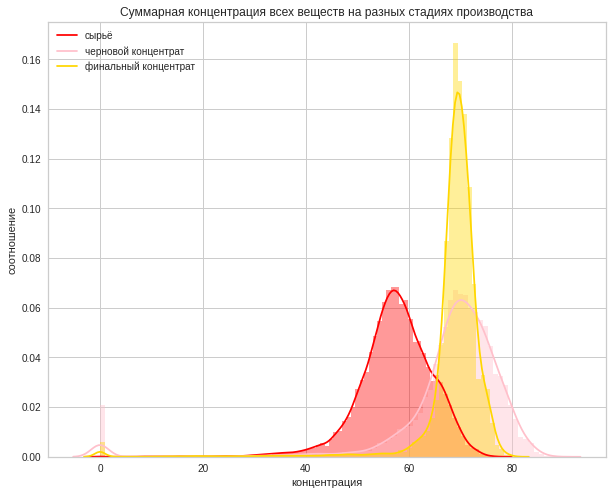

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(rougher_input_feed_concentrate,\
                        kde=True, bins=90, color='red')
sns.distplot(rougher_output_concentrate,\
                        kde=True, bins=90, color= 'pink')
sns.distplot(final_output_concentrate,\
                        kde=True, bins=90, color='gold')
plt.legend(['сырьё', 'черновой концентрат', 'финальный концентрат'])
plt.title('Суммарная концентрация всех веществ на разных стадиях производства')
plt.xlabel('концентрация')
plt.ylabel('соотношение')


plt.show()

Вывод: видим, что аномальные значения лежат где-то возле нуля. Данные со значением концентрации до 20 можно удалить для построения более точной модели.

In [54]:
df_full =  df_full.query('@rougher_input_feed_concentrate > 20 &\
@rougher_output_concentrate > 20 & @final_output_concentrate > 20')

Теперь подготовим наши выборки для обучения. Для этого добавим целевые признаки по индексам. Чтобы индексы в обеих выборках совпадали. Так мы отберём из тренировочных данных выбросы, которые мы обнаружили в df_full. Тоже самое действие проделаем и с тестовой выборкой.

In [55]:
df_train_for_models = pd.merge(df_train_for_analysis, df_full[['rougher.output.recovery', 'final.output.recovery']],
        left_index=True, right_index=True)

In [56]:
print('\n Тренировочные данные: \n количество наблюдений до предобработки {},\n количество наблюдений после предобработки {},\n количество \
пропусков {},\n количество дубликатов {}'
      .format(len(df_train_for_analysis), len(df_train_for_models), df_train_for_models.isnull().sum().sum(), df_train_for_models.duplicated().sum()))


 Тренировочные данные: 
 количество наблюдений до предобработки 14149,
 количество наблюдений после предобработки 13358,
 количество пропусков 0,
 количество дубликатов 0


In [57]:
df_test_for_models = pd.merge(df_test_for_analysis, df_full[['rougher.output.recovery', 'final.output.recovery']],
        left_index=True, right_index=True)

In [58]:
print('\n Тестовые данные: \n количество наблюдений до предобработки {},\n количество наблюдений после предобработки {},\n количество \
пропусков {},\n количество дубликатов {}'
      .format(len(df_test_for_analysis), len(df_test_for_models), df_test_for_models.isnull().sum().sum(), df_test_for_models.duplicated().sum()))


 Тестовые данные: 
 количество наблюдений до предобработки 5290,
 количество наблюдений после предобработки 5124,
 количество пропусков 0,
 количество дубликатов 0


Вывод: тестовые и тренировочные данные подготовлены для обучения моделей.

### Итоги анализа данных

Анализ концентрации металлов на различных этапах очистки показал, что с каждым этапом очистки концентрация золота заметно увеличивается, в то время как концентрация серебра наоборот снижается. Свинец показывает небольшое увелечение концентрации. 


Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках показало, что распределения размеров гранул не сильно отличаются друг от друга, оценка модели будет правильной.

Анализ суммарной концентрации всех веществ на разных стадиях показал, что данные со значением концентрации до 20 можно удалить для построения более точной модели.

Отобрали из тренировочных данных выбросы, которые мы обнаружили в df_full. Тоже самое действие проделаем и с тестовой выборкой. 

Анализ данных позволил сформировать данные для обучения моделей.

## Обучение модели и оценка качества

Для оценки качества моделей будем использовать следующие метрики. 

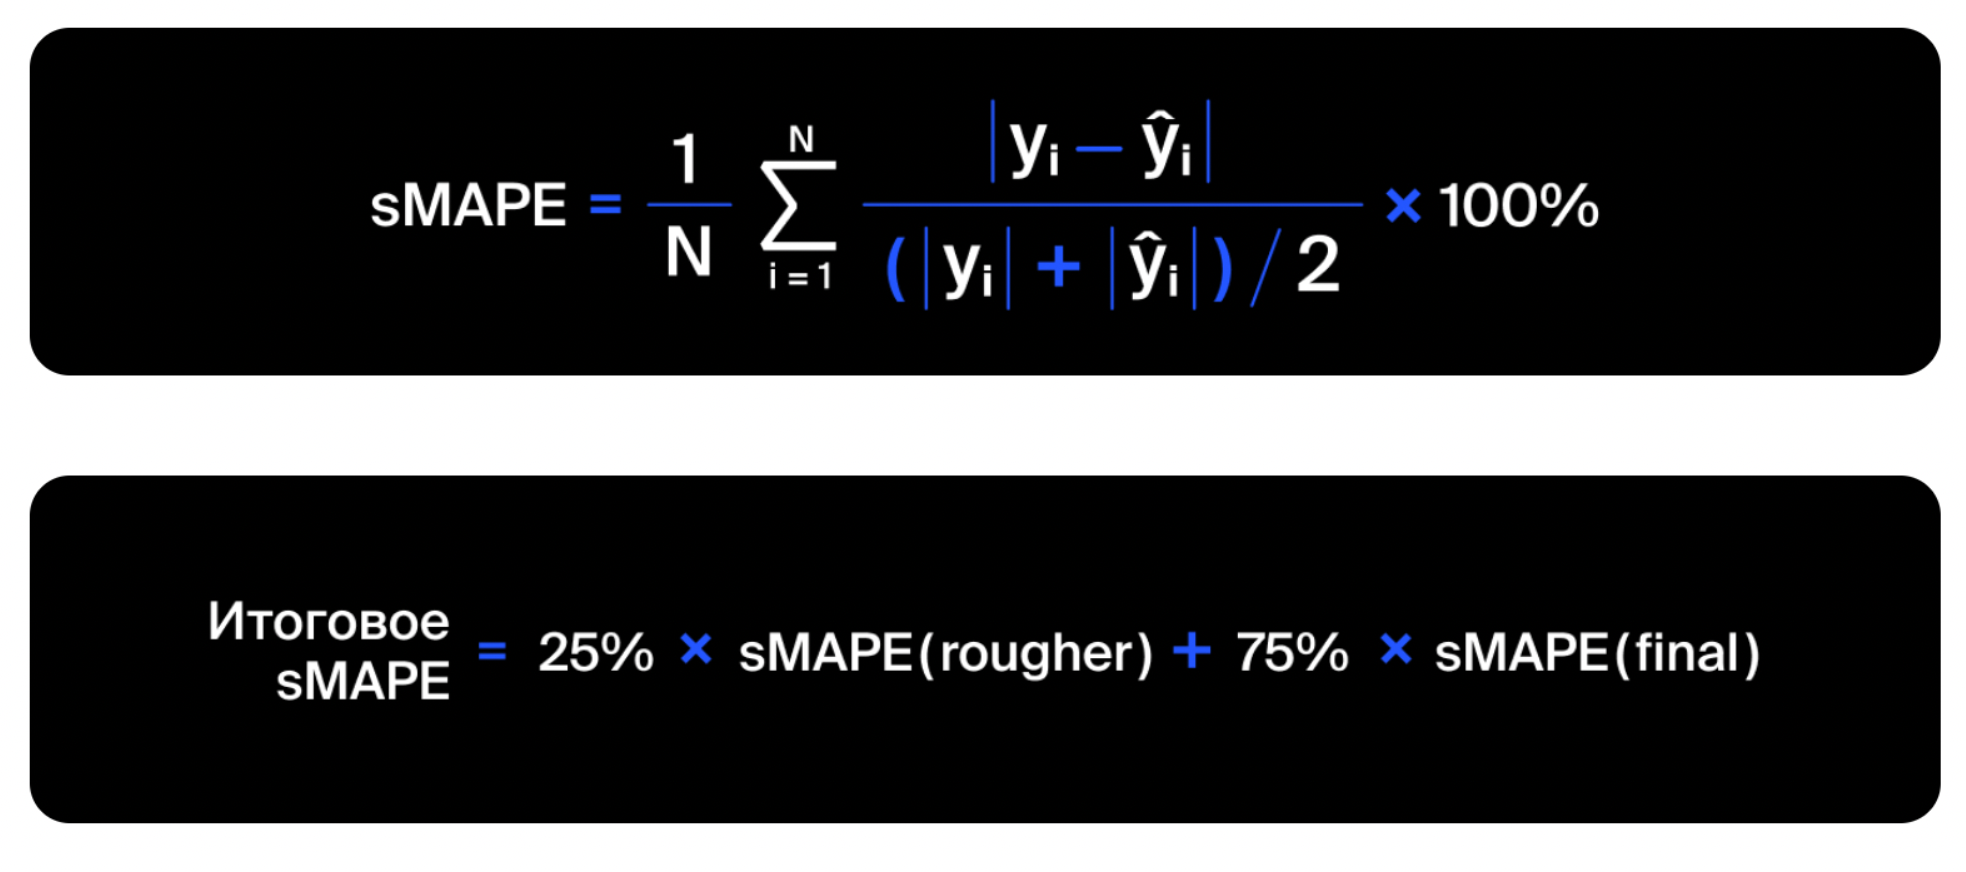

sMAPE

In [59]:
def sMAPE(true, pred):
    """
   функция считает sMAPE
   """
    return np.mean(abs(true - pred)/((abs(true)+abs(pred))/2))*100

Итоговый sMAPE

In [60]:
def the_total_sMAPE(sMAPE_rougher,sMAPE_final):
    """
   функция считает итоговый sMAPE
   """
    return (0.25 * sMAPE_rougher + 0.75 * sMAPE_final)

Для тестирования моделей кросс-валидацией необходимо создать собственный scorer, который будет высчитывать sMAPЕ. Для этого применим метод make_scorer.

In [61]:
smape_score = make_scorer(sMAPE, greater_is_better=False)

Разделим подготовленные тренировочные и тестовые выборки на признаки и целевые признаки.

In [62]:
x_train = df_train_for_models.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_train_rougher = df_train_for_models['rougher.output.recovery']
y_train_final = df_train_for_models['final.output.recovery']
x_test = df_test_for_models.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
y_test_rougher = df_test_for_models['rougher.output.recovery']
y_test_final = df_test_for_models['final.output.recovery']

Будем испльзовать для обучения модели на основании следующих алгоритмов:
- Регрессия дерева решений;

- Регрессор случайного леса;

- Регрессия LASSO;

- Гребневая регрессия (ридж-регрессия).


Для автоматизации процесса вычисления будем использовать pipeline.

In [64]:
lasso_model = make_pipeline(StandardScaler(), Lasso(random_state=42))
forestregressor_model = make_pipeline(RandomForestRegressor(random_state=42))
treeregressor_model = make_pipeline(DecisionTreeRegressor(random_state=42))
ridgecv_model = make_pipeline(StandardScaler(), RidgeCV())

Определим область подбора параметров.

In [65]:
forestregressor_params = {'randomforestregressor__n_estimators':range(10, 61, 10),
                          'randomforestregressor__max_depth':range (1,20),
                          'randomforestregressor__max_features':['sqrt','log2']}
treeregressor_params= {'decisiontreeregressor__max_depth':range (1,11),
                      'decisiontreeregressor__min_samples_split': range(10, 61, 10)}
lasso_params = {'lasso__alpha':[5., 1., .5]}

ridgecv_params = {'ridgecv__alphas':[5., 1., .5]}


Зададим кросс-валидацию для моделей.

In [66]:
grid_rougher_lasso = RandomizedSearchCV(lasso_model, param_distributions = lasso_params, cv=10,
                                            scoring = smape_score, n_jobs=-1)
grid_final_lasso = RandomizedSearchCV(lasso_model, param_distributions = lasso_params, cv=10,
                                            scoring = smape_score, n_jobs=-1)

In [67]:
grid_rougher_forestregressor = RandomizedSearchCV(forestregressor_model, cv=5,scoring = smape_score, 
                                                  param_distributions = forestregressor_params, n_jobs=-1)
grid_final_forestregressor = RandomizedSearchCV(forestregressor_model, cv=5,scoring = smape_score, 
                                                param_distributions = forestregressor_params, n_jobs=-1)

In [68]:
grid_rougher_treeregressor = RandomizedSearchCV(treeregressor_model, cv=5,scoring = smape_score, 
                                                param_distributions = treeregressor_params, n_jobs=-1)
grid_final_treeregressor = RandomizedSearchCV(treeregressor_model, cv=5,scoring = smape_score, 
                                              param_distributions = treeregressor_params, n_jobs=-1)

In [69]:
grid_rougher_ridgecv = RandomizedSearchCV(ridgecv_model, param_distributions = ridgecv_params,scoring = smape_score,
                                          n_jobs=-1)
grid_final_ridgecv = RandomizedSearchCV(ridgecv_model, param_distributions = ridgecv_params, scoring = smape_score,n_jobs=-1)

Обучим модели и глянем на лучшие параметры.

1. Регрессия LASSO

In [70]:
grid_rougher_lasso.fit(x_train,y_train_rougher)
grid_final_lasso.fit(x_train,y_train_final)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('lasso',
                                              Lasso(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'lasso__alpha': [5.0, 1.0, 0.5]},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

In [71]:
grid_rougher_lasso.best_score_

-6.038559845912229

In [72]:
grid_rougher_lasso.best_params_

{'lasso__alpha': 0.5}

In [73]:
grid_final_lasso.best_score_

-8.49364130371962

In [74]:
grid_final_lasso.best_params_

{'lasso__alpha': 0.5}

2. Регрессор случайного леса

In [75]:
grid_rougher_forestregressor.fit(x_train,y_train_rougher)
grid_final_forestregressor.fit(x_train,y_train_rougher)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(1, 20),
                                        'randomforestregressor__max_features': ['sqrt',
                                                                                'log2'],
                                        'randomforestregressor__n_estimators': range(10, 61, 10)},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

In [76]:
grid_rougher_forestregressor.best_score_

-6.050344336318481

In [77]:
grid_rougher_forestregressor.best_params_

{'randomforestregressor__n_estimators': 50,
 'randomforestregressor__max_features': 'log2',
 'randomforestregressor__max_depth': 4}

In [78]:
grid_final_forestregressor.best_score_

-5.884632431282772

In [79]:
grid_final_forestregressor.best_params_

{'randomforestregressor__n_estimators': 30,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__max_depth': 5}

3. Регрессия дерева решений

In [80]:
grid_rougher_treeregressor.fit(x_train,y_train_rougher)
grid_final_treeregressor.fit(x_train,y_train_rougher)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('decisiontreeregressor',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'decisiontreeregressor__max_depth': range(1, 11),
                                        'decisiontreeregressor__min_samples_split': range(10, 61, 10)},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

In [81]:
grid_rougher_treeregressor.best_score_

-7.095949642086865

In [82]:
grid_rougher_treeregressor.best_params_

{'decisiontreeregressor__min_samples_split': 10,
 'decisiontreeregressor__max_depth': 3}

In [83]:
grid_final_treeregressor.best_score_

-7.095949642086865

In [84]:
grid_final_treeregressor.best_params_

{'decisiontreeregressor__min_samples_split': 10,
 'decisiontreeregressor__max_depth': 3}

4. Гребневая регрессия (ридж-регрессия)

In [85]:
grid_rougher_ridgecv.fit(x_train,y_train_rougher)
grid_final_ridgecv.fit(x_train,y_train_rougher)

RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('ridgecv', RidgeCV())]),
                   n_jobs=-1,
                   param_distributions={'ridgecv__alphas': [5.0, 1.0, 0.5]},
                   scoring=make_scorer(sMAPE, greater_is_better=False))

In [86]:
grid_rougher_ridgecv.best_score_

-7.14393871621836

In [87]:
grid_rougher_ridgecv.best_params_

{'ridgecv__alphas': 5.0}

In [88]:
grid_final_ridgecv.best_score_

-7.14393871621836

In [89]:
grid_final_ridgecv.best_params_

{'ridgecv__alphas': 5.0}

Самые лучшие результаты у модели Регрессия LASSO. Посмотрим на финальную оценку и выберем самую минимальную.

In [90]:
the_total_sMAPE(grid_rougher_lasso.best_score_, grid_final_lasso.best_score_)

-7.879870939267772

In [91]:
the_total_sMAPE(grid_rougher_forestregressor.best_score_, grid_final_forestregressor.best_score_)

-5.9260604075417

In [92]:
the_total_sMAPE(grid_rougher_treeregressor.best_score_, grid_final_treeregressor.best_score_)

-7.095949642086865

In [93]:
the_total_sMAPE(grid_rougher_ridgecv.best_score_, grid_final_ridgecv.best_score_)

-7.14393871621836

Выбираем модель Регрессии LASSO и проверяем на тестовой выборке.

In [94]:
rougher_pred = grid_rougher_lasso.predict(x_test)
final_pred = grid_final_lasso.predict(x_test)

In [95]:
the_total_sMAPE(sMAPE(y_test_rougher,rougher_pred),sMAPE(y_test_final,final_pred))

6.3575502609820385

Для того, чтобы оценить полученный результат построим константную модель. Константная модель будет предсказывать средние значения.

In [97]:
constant_rougher = make_pipeline(DummyRegressor(strategy='mean'))
constant_final = make_pipeline(DummyRegressor(strategy='mean'))

In [98]:
constant_rougher.fit(x_train,y_train_rougher)
constant_final.fit(x_train,y_train_final)

Pipeline(steps=[('dummyregressor', DummyRegressor())])

In [99]:
constant_rougher_pred = constant_rougher.predict(x_test)
constant_final_pred = constant_final.predict(x_test)

In [100]:
the_total_sMAPE(sMAPE(y_test_rougher,constant_rougher_pred),sMAPE(y_test_final,constant_final_pred))

7.473890325358191

Видим, что наша метрика получилась ниже, чем на константной модели. Значит мы сделали всё верно.

### Итоги обучения  модели и оценки качества
Для обучения были использованы модели на основании следующих алгоритмов:
- Регрессия дерева решений;

- Регрессор случайного леса;

- Регрессия LASSO;

- Гребневая регрессия (ридж-регрессия).

Лучший результат показала модель Lasso(random_state=42, lasso__alpha = 0.5). На тренировочной выборке было получено the_total_sMAPE = -7.879870939267772; на тестовой выборке the_total_sMAPE = 6.3575502609820385. 
Значение метрики получилась ниже, чем на константной модели the_total_sMAPE = 7.473890325358191. Делаем вывод о том, что данную модель можно использовать для  оптимизировать производства. 

## Общий вывод
Нами была проведена подготовки данных к анализу, которая включала:
- ознакомление c наборами данных: df_full, df_test, df_train. Мы выявили:

1. в данных есть пропущенные значения. В df_test видим отсутствие ряда признаков. В тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. df_full содержит обучающую и тестовую выборки со всеми признаками.
2. 'date' в не верном формате 'object' .
3. df_full, df_train присутствуют данные о содержании серебра (Ag), вещества (Sol), свинеца (Pb) и золота (Au).

- расчёт эффективности обогащения показал, что при вычислении MAE(средней абсолютной разницы между прогнозируемыми значениями и фактическими значениями) получено значение 9.73512347450521e-15. MAE достаточно мало, что свидетельствует о том, что эффективность расчитана верно.

- анализ признаков показал, что в тестовой выборке у нас отсутствуют все этапы на которых были получены параметры продукта из сырья - итоговые значения после каждого этапа обработки. Что привело к удалению из df_train признаков, которые отсутствуют в df_test.

- заполнение пропусков в тренировочных и тестовых данных было осуществлено с помощью индексации данных датой и временем получения информации. На основании того, что соседние по времени параметры часто похожи, осуществили замену пропусков с использованием метода k-ближайших соседей.


Последующий анализ данных показал:
- с каждым этапом очистки концентрация золота заметно увеличивается, в то время как концентрация серебра наоборот снижается. Свинец показывает небольшое увелечение концентрации.

In [101]:
table_of_metal_concentrations

,Наименование металла,Концентрация до флотации,Концентрация после флотации,Концентрация после первичной очистки,Финальный концентрат
0,Au,8.125839,20.280214,32.841295,45.011244
1,Pb,3.539122,7.751543,10.164130,10.115748
2,Ag,8.593648,12.098115,8.507349,5.066094


- распределения размеров гранул не сильно отличаются на обучающей и тестовой выборках, оценка модели будет правильной.

- данные со значением концентрации до 20 можно удалить для построения более точной модели.Мы отобрали из тренировочных данных выбросы, которые мы обнаружили в df_full. Тоже самое действие проделаем и с тестовой выборкой.


На этапе обучения  модели и оценки качества мы использовали модели на основании следующих алгоритмов:
- Регрессия дерева решений;

- Регрессор случайного леса;

- Регрессия LASSO;

- Гребневая регрессия (ридж-регрессия).

Лучший результат показала модель Lasso(random_state=42, lasso__alpha = 0.5). На тренировочной выборке было получено the_total_sMAPE = -7.879870939267772; на тестовой выборке the_total_sMAPE = 6.3575502609820385. 
Значение метрики получилась ниже, чем на константной модели the_total_sMAPE = 7.473890325358191. Делаем вывод о том, что данную модель можно использовать для  оптимизации производства. 